---
title: Next Character Prediction using MLP
author: ["Guntas Singh Saran"]
date: "2024-03-21"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
image: "MLPToken.svg"
categories: ["Neural Networks", "NLP"]

---

## **Check out the Streamlit App hosted at https://tensionflowcharpredict.streamlit.app/**

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda


## **EnWik8 Corpus**

In [3]:
with open("./enwik8", 'r') as xml_file:
    wiki = xml_file.read()
print(len(wiki))
wiki = wiki[:(len(wiki)//10)]
print(len(wiki))
print(wiki[:5000])
new_wiki = ""
for char in wiki:
    if char not in ['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']:
      continue
    new_wiki += char

characters = sorted(list(set(new_wiki)))
print(len(characters))
print(characters)

99621832
9962183
<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd" version="0.3" xml:lang="en">
  <siteinfo>
    <sitename>Wikipedia</sitename>
    <base>http://en.wikipedia.org/wiki/Main_Page</base>
    <generator>MediaWiki 1.6alpha</generator>
    <case>first-letter</case>
      <namespaces>
      <namespace key="-2">Media</namespace>
      <namespace key="-1">Special</namespace>
      <namespace key="0" />
      <namespace key="1">Talk</namespace>
      <namespace key="2">User</namespace>
      <namespace key="3">User talk</namespace>
      <namespace key="4">Wikipedia</namespace>
      <namespace key="5">Wikipedia talk</namespace>
      <namespace key="6">Image</namespace>
      <namespace key="7">Image talk</namespace>
      <namespace key="8">MediaWiki</namespace>
      <namespace key="9">MediaWiki talk</namespac

In [4]:
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["`"] = 0 ## Pad Character
itos = {i : s for s, i in stoi.items()}
pprint(itos)

{0: '`',
 1: '\t',
 2: '\n',
 3: ' ',
 4: '!',
 5: '"',
 6: '#',
 7: '$',
 8: '%',
 9: '&',
 10: "'",
 11: '(',
 12: ')',
 13: '*',
 14: '+',
 15: ',',
 16: '-',
 17: '.',
 18: '/',
 19: '0',
 20: '1',
 21: '2',
 22: '3',
 23: '4',
 24: '5',
 25: '6',
 26: '7',
 27: '8',
 28: '9',
 29: ':',
 30: ';',
 31: '<',
 32: '=',
 33: '>',
 34: '?',
 35: '@',
 36: 'A',
 37: 'B',
 38: 'C',
 39: 'D',
 40: 'E',
 41: 'F',
 42: 'G',
 43: 'H',
 44: 'I',
 45: 'J',
 46: 'K',
 47: 'L',
 48: 'M',
 49: 'N',
 50: 'O',
 51: 'P',
 52: 'Q',
 53: 'R',
 54: 'S',
 55: 'T',
 56: 'U',
 57: 'V',
 58: 'W',
 59: 'X',
 60: 'Y',
 61: 'Z',
 62: '[',
 63: '\\',
 64: ']',
 65: '^',
 66: '_',
 67: 'a',
 68: 'b',
 69: 'c',
 70: 'd',
 71: 'e',
 72: 'f',
 73: 'g',
 74: 'h',
 75: 'i',
 76: 'j',
 77: 'k',
 78: 'l',
 79: 'm',
 80: 'n',
 81: 'o',
 82: 'p',
 83: 'q',
 84: 'r',
 85: 's',
 86: 't',
 87: 'u',
 88: 'v',
 89: 'w',
 90: 'x',
 91: 'y',
 92: 'z',
 93: '{',
 94: '|',
 95: '}',
 96: '~'}


## Generating the Training Samples

![](./MLPToken.svg)

In [5]:
block_size = 50
X, Y = [], []
context = [0] * block_size
for idx in range(len(new_wiki)):
  ix = stoi[new_wiki[idx]]
  X.append(context)
  Y.append(ix)
  # print(''.join(itos[i] for i in context), '--->', itos[ix])
  context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [6]:
X.shape, Y.shape

(torch.Size([9924444, 50]), torch.Size([9924444]))

In [7]:
# Embedding layer for the context
emb_dim = 25
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [8]:
emb.weight.shape

torch.Size([97, 25])

## Function to visualize the embedding in 2d space using **t-SNE**

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


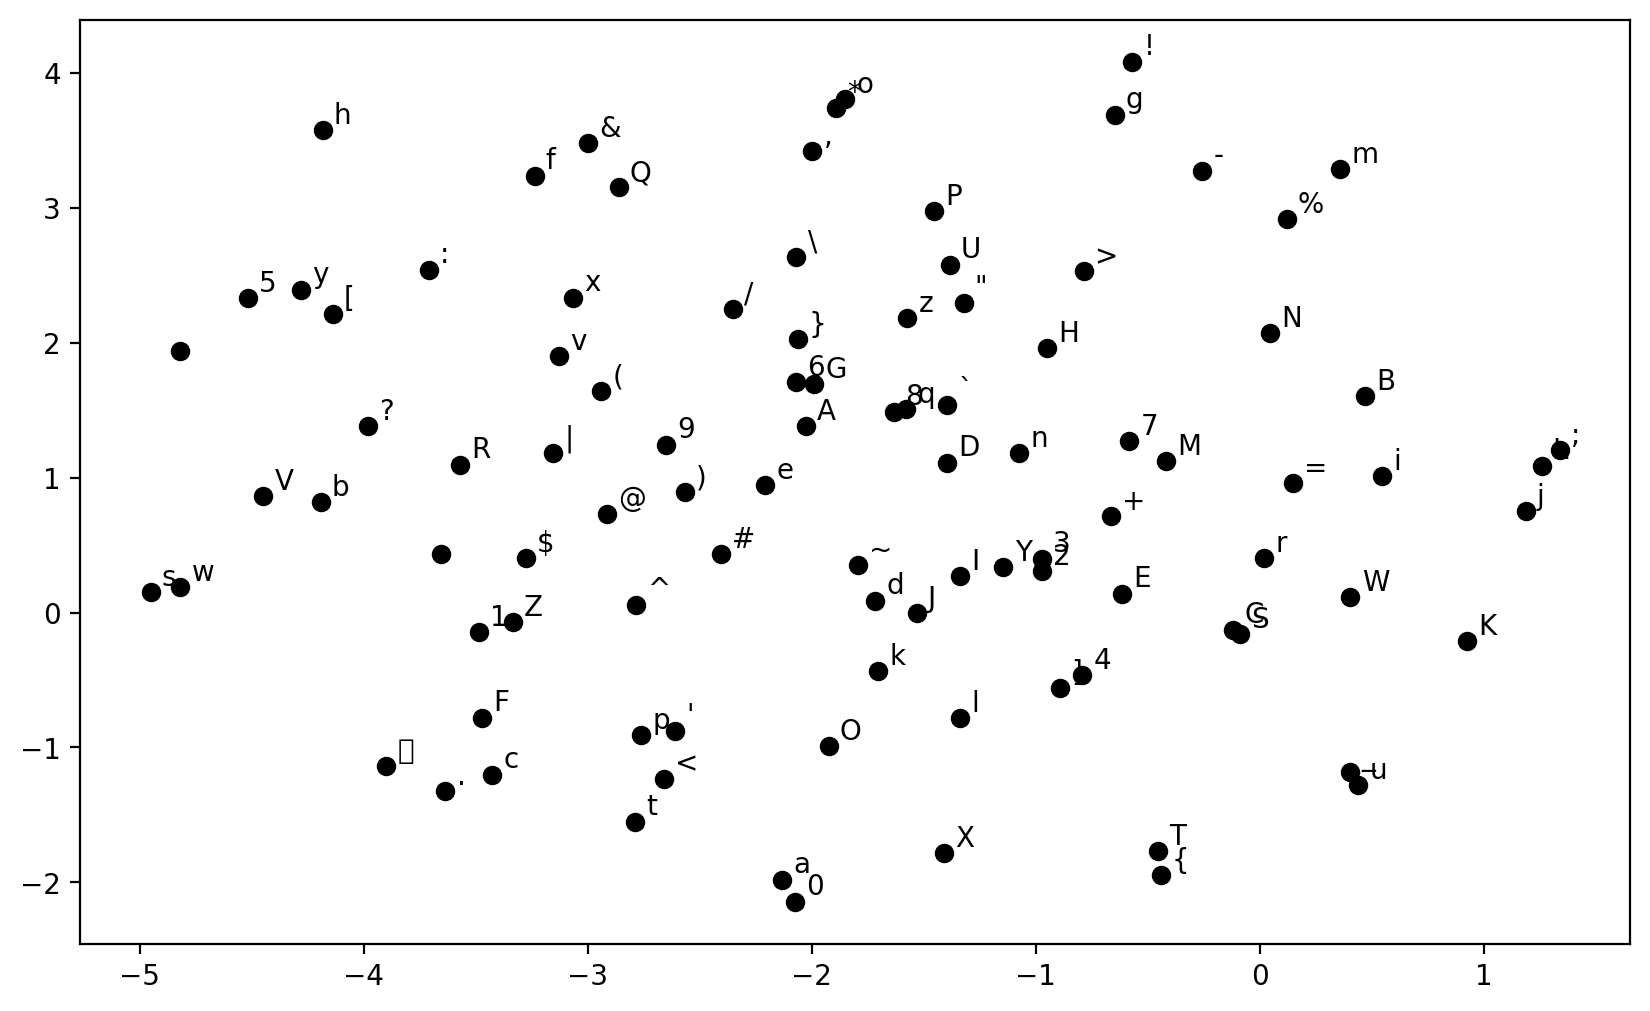

In [11]:
def plot_emb(emb, itos, ax = None):
    if emb.weight.shape[1] != 2:
      tsne = TSNE(n_components = 2)
      emb_new = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    if ax is None:
        fig, ax = plt.subplots(figsize = (10, 6))
    for i in range(len(itos)):
        if emb.weight.shape[1] == 2:
          x, y = emb.weight[i].detach().cpu().numpy()
          ax.scatter(x, y, color='k')
          ax.text(x + 0.05, y + 0.05, itos[i])
        else:
          x, y = emb_new[i]
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

## Structure of the **MLP**

![Alt](./Embed.svg)
![Alt](./ModelEmbed.svg)

In [12]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size1, hidden_size2):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.tanh(self.lin1(x))
    x = torch.tanh(self.lin2(x))
    x = self.lin3(x)
    return x

In [15]:
model = NextChar(block_size, len(stoi), emb_dim, 300, 100).to(device)
model = torch.compile(model)

In [16]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([97, 25])
_orig_mod.lin1.weight torch.Size([300, 1250])
_orig_mod.lin1.bias torch.Size([300])
_orig_mod.lin2.weight torch.Size([100, 300])
_orig_mod.lin2.bias torch.Size([100])
_orig_mod.lin3.weight torch.Size([97, 100])
_orig_mod.lin3.bias torch.Size([97])


## Generating names from untrained model

In [17]:
import warnings
warnings.filterwarnings("ignore")

g = torch.Generator()
g.manual_seed(4200)
def generate_text(model, itos, stoi, block_size, max_len, start_str = None):

    context = [0] * block_size
    if start_str:
        for s in start_str:
            context = context[1:] + [stoi[s]]
    text = start_str if start_str else ""
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text

my_str = generate_text(model, itos, stoi, block_size, 1000, "this is ")
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(decoded_string)

this is j J=w$k.B{g7Z_=Y}|u4fbt(j'!\s20,xjUPl}Ie+1#nWT!4lZ6}+4;PX	u"`,ebRT@;vh,9R2^GHL/q79o:~BhZWW~r'l}crAt8	l3,Z0}Hc.I,_7eX5Xy:@Tqe#G_X
*nlHop:"=&ZEfwB(*MYOqi=^$()SKzi^anUOjv]TS ^-^p6?j;:Qp+L,b*0sx|SdN*<W_yG_@L[~_O4h],cirlS5*25}u$Ef,e\Xy#W:!>{G<K9)\@jC|+dN&n_Zdb"u'DgCZV<[+E/H'@=KplHJ-NZMpG[[k/Dzb6_+0O=n,fvt{J{u!kNwewv(RDsMAS@j_[#1Ml&O`vP;!i8yn9Ei|Q6u>f";bH|~mfch_e/%U.fq30ZF21}i4Id}yWnAR9do`9d`W#ZbOT{U@oS$(0%)+[^LX2M]kGxQ?6N!NeY_"3WePSR	o/uqnx/*&z@_sv-X1S<=Rrj'>`2K=%Z
}RNRh	2\`vOcL: :hq2Lo_xOd`Pis\8.t#xAY	k#v!n^>L.-f-dx11&j 5b8>Ab4!_fI"<1Q)!zNk~`D_X|3
s#G[yX[E9BaA]SDGwHD'lJxSyJBW0yzV
)0r7"}9c{>_Zb;)] T0@YWLs?wLRo8V
.fO"BZoCjN3M,c!XtsTXlG<	x#g0~hlzjSgq<*cww9v%9)pPRPfQ5:6`Zh3h)=UZ{a=Z9yuTLTdp?>3m[rIPr	,f}p 5F&z%@"a$!-\eMciXSOD?r gZD55#08ehG\K\%:Mt'+RMu&1K/HL}<8`a%U@AX]}<ELk;R,jHU+ .P6Bt7$(K8!kw!S|?i3j)p@[_I1VFd&dDo0xD~U	Qobx<kII~!2u"]iQs96>FdUeJr%4:0)6^D>_*sFmKqDO'(PkV`/?[SR;+
tXEy#-R_^,AjO#4ZHsx 0Bcyr Tf(53='rgZ~EQ_P<hK&'@
"|lg
*<pO{]k)P|jj"\Aj9nz(B*h>]'${r,q,jhvbqt5b$G-)PLX,4Z	w6#7pQ.

## Model Training

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.02)
batch_size = 4096
print_every = 5
for epoch in range(10000):
  total_loss = 0
  for i in range(0, X.shape[0], batch_size):
      x = X[i : i + batch_size]
      y = Y[i : i + batch_size]
      y_pred = model(x)
      loss = loss_fn(y_pred.view(-1, len(stoi)), y.view(-1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

  if epoch % print_every == 0:
      average_loss = total_loss / (X.shape[0] / batch_size)
      print(f"Epoch {epoch}, Loss: {average_loss}")

Epoch 0, Loss: 2.8350139496105684
Epoch 5, Loss: 2.3314288813606963
Epoch 10, Loss: 2.295441793260227
Epoch 15, Loss: 2.2891312827811183
Epoch 20, Loss: 2.2772508836170773
Epoch 25, Loss: 2.270781237766947
Epoch 30, Loss: 2.265585624811277
Epoch 35, Loss: 2.2659898983344493
Epoch 40, Loss: 2.262110797554896
Epoch 45, Loss: 2.256057252406753
Epoch 50, Loss: 2.2499491346760996
Epoch 55, Loss: 2.2512255706146957
Epoch 60, Loss: 2.2480657476478894
Epoch 65, Loss: 2.242697944089291
Epoch 70, Loss: 2.2402018668078614
Epoch 75, Loss: 2.241432100314637
Epoch 80, Loss: 2.239732624009277
Epoch 85, Loss: 2.2423875842910492
Epoch 90, Loss: 2.238643688931875
Epoch 95, Loss: 2.2355767357427814
Epoch 100, Loss: 2.2356967695992984
Epoch 105, Loss: 2.2369650068979148
Epoch 110, Loss: 2.235218913750318
Epoch 115, Loss: 2.231936918430503
Epoch 120, Loss: 2.2326218815552714
Epoch 125, Loss: 2.2282290417226394
Epoch 130, Loss: 2.2294567735641615
Epoch 135, Loss: 2.230277611866996
Epoch 140, Loss: 2.2264508

KeyboardInterrupt: 

## **Saving the model**

In [19]:
torch.save(model.state_dict(), "modelWiki.pth")

In [20]:
model.state_dict()

OrderedDict([('_orig_mod.emb.weight',
              tensor([[-0.2127, -0.2873,  0.2147,  ..., -0.5042,  0.1505,  0.4789],
                      [-0.0885, -1.3026, -0.3783,  ...,  2.1375, -0.1139, -0.6655],
                      [ 1.6558, -0.5986,  0.4964,  ...,  1.9797,  0.1884, -0.6399],
                      ...,
                      [ 0.9190, -1.1540, -2.1688,  ...,  3.3804, -1.6150, -0.1725],
                      [ 0.5419, -0.5989,  1.6368,  ...,  0.7716,  0.8263,  1.3183],
                      [-0.0912,  0.2951,  1.2806,  ..., -0.8260,  0.4481,  0.3524]],
                     device='cuda:0')),
             ('_orig_mod.lin1.weight',
              tensor([[-0.9020,  0.2586,  1.4684,  ..., -5.8197, -1.0540,  0.1886],
                      [ 0.6868,  1.0851, -0.5121,  ..., -1.9412,  1.7108,  1.2154],
                      [-0.5979, -0.4234,  0.4775,  ..., -1.3133,  1.6652, -3.1809],
                      ...,
                      [-0.2150,  0.7051,  0.4703,  ..., -1.0828,  0.1105

## Visualize the Learnt Embedding

<Axes: >

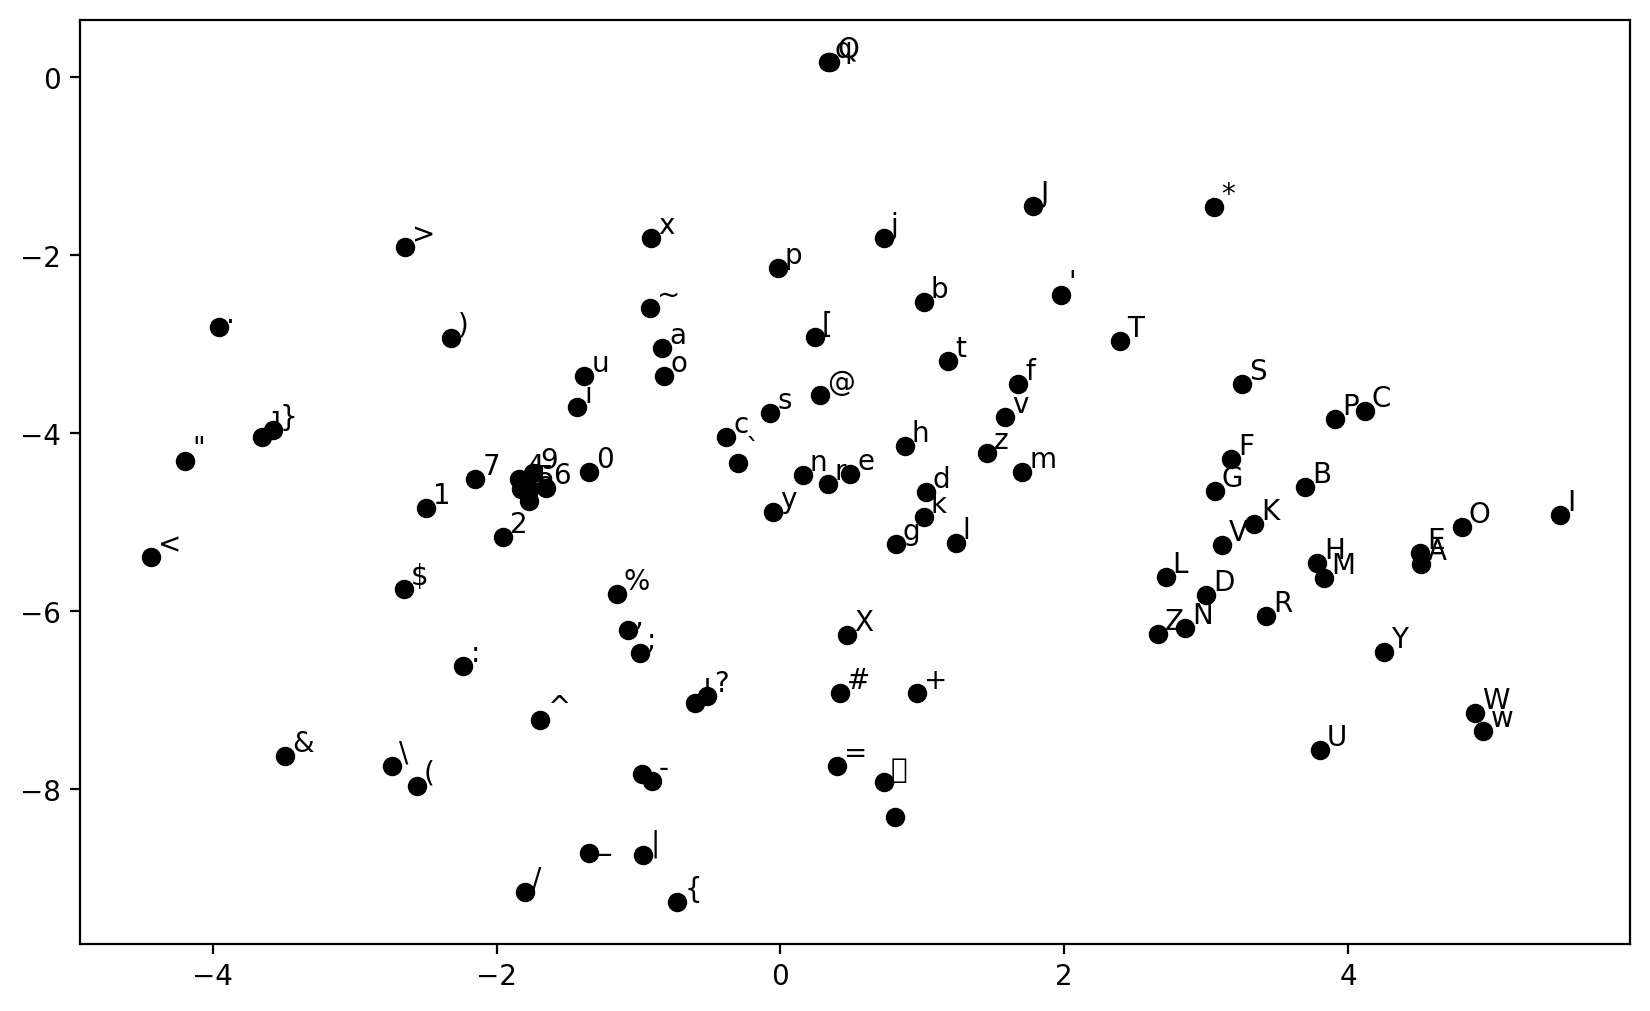

In [21]:
plot_emb(model.emb, itos)

## Generating Strings from the Model

In [22]:
start = np.random.randint(0, len(new_wiki) - block_size - 1)
end = start + 1000
while new_wiki[start] != " ":
  start += 1

while new_wiki[end] != " ":
  end -= 1

seed_text = new_wiki[start + 1 : end]
print(f"==================Seed Text=================\n{seed_text}\n")
my_str = generate_text(model, itos, stoi, block_size, 10000, seed_text)
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(f"\n===============Predicted Text===============\n{decoded_string}")

==================Seed Text=================
and watched over its beginnings in his diocese, providing for the needs of a monastery outside the walls of Milam, as Saint Augustine recounts in his ''Confessions''. Ambrose also made successful efforts to improve the moral life of women in the Milan of his time by promoting the permament institution of Virgins, as also of widows. His exhortations and other interventions have survived in various writings: ''De virginibus'', ''De viduis'', ''De virginitate'', ''De institutione virginis'', ''De exhortatione virginitatis'', and ''De lapsu virginis consecratae''. Ambrose was the only Father of the Church to leave behind so many writings on the subject and his attentions naturally enough led to the formation of  communities which later became formal monasteries of women. 

It is against this background that two religious orders or congregations, one of men and one of women, when founded in the Milan area during the [[13th century|13th]] and [[15